# Analyzing Agilent chromatograms exported to .cdf format

In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# read in anonymized filepath
with open('chrom_path.txt', 'r') as file:
    instrument_path = file.readlines()[0]

# pull all of the .cdf files
chrom_files = []
for file in os.listdir(instrument_path):
    if file.endswith('.cdf'):
        chrom_files.append(file)

chrom_file = chrom_files[0]  # grab one from the list
filepath = os.path.join(instrument_path, chrom_file)

### Check the file's variables

In [2]:
ds = Dataset(filepath, 'r')
for key in ds.variables.keys():
    print(key)

actual_sampling_interval
actual_delay_time
actual_run_time_length
detector_maximum_value
detector_minimum_value
peak_retention_time
peak_name
peak_amount
peak_start_time
peak_end_time
peak_width
peak_area
peak_area_percent
peak_height
peak_height_percent
baseline_start_time
baseline_start_value
baseline_stop_time
baseline_stop_value
peak_start_detection_code
peak_stop_detection_code
retention_index
peak_asymmetry
peak_efficiency
ordinate_values


### Define objects that can structure peak data for us

In [3]:
class Peak:
    """
    Encapsulates individual peak data

    Attributes:
        name (str):              Name of the analyte to which the peak belongs.
        start_time (numeric):    Retention time at which peak integration begins.
        stop_time (numeric):     Retention time at which peak integration ends.
        apex_time (numeric):     Retention time of the peak apex.
        height (numeric):        Signal intensity at the apex, or max height of the peak.
    """

    def __init__(self, name, start, stop, signal, time):
        """
        Initializes the Peak object.

        Params:
            name (str):           Name of the analyte to which the peak belongs.
            start (numeric):      Retention time at which peak integration begins.
            stop (numeric):       Retention time at which peak integration ends.
            signal (np.ndarray):  Array of signal intensities--the chromatogram itself.
            time (np.ndarray):    The time axis of the chromatogram in minutes.
        """
        
        self.name = name
        self.start_time = start  # beginning of integration
        self.stop_time = stop    # end of integration
        self.apex_time, self.height = self._get_apex(signal, time)

    def _get_apex(self, signal, time):
        """
        Get the retention time and height of the peak apex

        Params:
            signal (np.ndarray):  Array of signal intensities--the chromatogram itself.
            time (np.ndarray):    The time axis of the chromatogram in minutes.
        """

        # find indices in the time array that match the start and stop times
        start_idx = (np.abs(time - self.start_time)).argmin()
        stop_idx = (np.abs(time - self.stop_time)).argmin()
    
        # extract the peak from the raw chromatogram
        peak_sig = signal[start_idx : stop_idx] 
    
        # get the index of the apex
        ret_time_idx = peak_sig.argmax() + start_idx  # offset to where the array slice was taken

        # get the peak height at its apex
        height = signal[ret_time_idx]

        # get the retention time in minutes corresponding to the peak apex
        ret_time = time[ret_time_idx]
    
        return ret_time, height

### Establish peak groups

##### We will do this by iterating over the named peaks and record the retention time at which an uninterrupted series of peaks begins and ends.  If they start back up again, as they do when interspersed with other named peaks, we will assemble those broken intervals into a list.

In [4]:
class Peak_Group:
    """
    Structures peaks into groups as defined by the chromatogram, as opposed to Agilent's method peak grouping per se.

    Attributes:
        name (str):              Name of the group.
        global_start (numeric):  Retention time of the first integration event of the first peak in the group.
        global_stop (numeric):   Retention time of the last integration event of the first peak in the group.
        defs (2D list):          List of start/stop intervals for each section of the group--equal to the global start/stop if the group is continuous.
        peaks (list):            List of Peak objects belonging to the group.
    """

    def __init__(self, name, peaks):
        """
        Initializes the Peak_Group object.

        Params:
            name (str):           Filename of chromatogram.
            peaks (list):         List of Peak objects belonging to the group.
        """
        self.name = name
        self.global_start = np.inf
        self.global_stop = 0
        self.defs = []
        self.peaks = []

        # TODO: allow initialization with a single peak without wrapping it in a list
        if peaks:
            try:
                self.peaks = [peak for peak in peaks]
            except TypeError:
                raise Exception("Peak_Group objects must be initialized with a list or Numpy array.")

            start, end = self._get_group_def_interval(self.peaks)
            self.global_start = start
            self.global_stop = end
            self.defs.append([start, end])
            
        else:
            self.defs.append([self.global_start, self.global_stop])

    def _get_group_def_interval(self, peaks):
        """
        Get the definition of a particular group interval

        Params:
            peaks (list):         List of Peak objects belonging to the group.
        """
        
        interval_start = np.inf
        interval_end = 0

        for peak in peaks:
            if peak.start_time < interval_start:
                interval_start = peak.start_time
            if peak.stop_time > interval_end:
                interval_end = peak.stop_time

        return interval_start, interval_end     

    def add_peaks(self, peaks):
        """
        Update the group with new peaks

        Params:
            peaks (list):         List of Peak objects to be added to the group.
        """

        interval_start, interval_stop = self._get_group_def_interval(peaks)
        
        if self.global_start < interval_start:
            self.global_start = interval_start
        if self.global_stop < interval_stop:
            self.global_stop = interval_stop

        self.peaks += peaks
        self.defs.append([interval_start, interval_stop])

### Build a class to parse the NetCDF4 data and handle the chromatogram-level functionality and data

In [5]:
class Chromatogram:
    """
    Encapsulates all the relevant data and calculations for chromatograms read in from NetCDF4 datasets.

    Attributes:
        name (str):           Filename of chromatogram, or other identifier.
        signal (np.ndarray):  Array of signal intensities--the chromatogram itself.
        time (np.ndarray):    The time axis of the chromatogram in minutes.
        peak_names (list):    List of peaks names in the order in which they were integrated.
        peaks (list):         List of Peak objects representing all the integrated peaks.
    """

    def __init__(self, dataset, name):
        """
        Initializes the chromatogram object.

        Params:
            dataset (netCDF4.dataset):  Dataset representing the .cdf file that was originally read in.
            name (str):                 Filename of chromatogram.
        """
        
        # filename for the chromatogram
        self.name = name
        
        # get the data sampling interval (usually 0.02s, but rarely 0.01s)
        interval = dataset.variables['actual_sampling_interval'][:].data
    
        # take the inverse to get the data rate in hertz
        data_hz = 1 / interval

        # pull the raw chromatogram itself
        self.signal = dataset.variables['ordinate_values'][:].data

        # define a time axis in minutes that matches the signal output 
        self.time = np.arange(self.signal.size) / data_hz / 60    # seconds / 50hz (or 100hz) / 60 seconds per minute

        # peak names are kept in a 2D byte array of shape (peak_number, character_limit).
        # the first dimension associates the peak and the second is an array of byte characters that add to form the name.
        self.peak_names = []
        for peak in ds.variables['peak_name'][:].data:
            name_string = "".join(character.decode('ASCII') for character in peak[:])  # decode the ASCII binary and group the character array into a string
            self.peak_names.append(name_string)

        # get start and stop times for each peak
        peak_starts = ds.variables['peak_start_time'][:].data / 60  # convert from seconds to minutes
        peak_stops = ds.variables['peak_end_time'][:].data / 60     # convert from seconds to minutes
        
        # set the list of peak objects
        self.peaks = self._get_peaks(peak_starts, peak_stops)

        # set the peak groups dictionary
        self.peak_groups = self._build_groups()

    def _get_peaks(self, starts, stops):
        """
        Build peak objects based on start/stop time arrays and return them as a list.

        Params:
            starts (np.ndarray):  Dataset representing the .cdf file that was originally read in.
            stops (np.ndarray):   Filename of chromatogram.
        """

        peak_list = []
        for idx, name in enumerate(self.peak_names):
            start_time = starts[idx]
            stop_time = stops[idx]
            peak = Peak(name, start_time, stop_time, self.signal, self.time)
            peak_list.append(peak)

        return peak_list

    def _build_groups(self):
        """
        Arrange peaks list into groups and return them as a dictionary.

        Params:
            None
        """

        unique_labels = []
        groups = {}
        for name, peak in zip(self.peak_names, self.peaks):
            if name not in unique_labels:
                group = Peak_Group(name, [peak])
                groups[name] = group
                unique_labels.append(name)
            else:
                groups[name].add_peaks([peak])

        return groups

    def plot(self, xmin=0, xmax=None, ymin=0, ymax=None):
        """
        Plot a labeled chromatogram scaled to user specifications

        Params:
            xmin (numeric):  Minimum value on the x-axis of the plot.
            xmax (numeric):  Maximum value on the x-axis of the plot.
            ymin (numeric):  Minimum value on the y-axis of the plot.
            ymax (numeric):  Maximum value on the y-axis of the plot.
        """
        
        # plot the chromatogram and zoom in
        fig = plt.Figure(figsize=(4,6))
        ax = plt.subplot()
        ax.plot(self.time, self.signal)
        ax.set_title(self.name, fontsize=8)
        ax.set_xlabel('Minutes')
        ax.set_ylabel('pA')
        ax.set_ybound(lower=ymin, upper=ymax)
        ax.set_xbound(lower=xmin, upper=xmax)

        # add in the peak labels
        for index, peak in enumerate(self.peaks):
            if peak and peak != 'e':  # exclude the solvent peak
                # set the height of the text label to rise just over the peak itself
                label_height = peak.height + 25

                # set rotation angle for the labels, with the default being 45 degrees
                rotation = 45

                # only place labels that are within the zoom window
                if not xmax:
                    xmax = self.time.max()
                if peak.apex_time > xmin and peak.apex_time < xmax:
                    # place the label at the top of the graph if the peak rises past it
                    if ymax and label_height > ymax:
                        label_height = ymax - 25  # set the label just under the top
                        rotation = 0              # do not slant the label at the top
                
                    # plot the label text at the tip of the peak
                    ax.text(peak.apex_time, label_height, peak.name, fontsize=8, rotation=rotation)

### Process the chromatogram dataset and list all the named peaks integrated in it

In [6]:
chrom = Chromatogram(ds, chrom_file)

# print out all the labeled peaks with their peak id
for index, name in enumerate(chrom.peak_names):
    if name:
        print(f"{index}: {name}")

0: Lights
1: Lights
2: Lights
3: Lights
4: Lights
5: Lights
6: Lights
7: Lights
8: Lights
9: Lights
10: Lights
11: Lights
12: Lights
13: Lights
14: Lights
15: Lights
16: Lights
17: Lights
18: Lights
19: Lights
20: Lights
21: Analyte
22: Analyte
23: Analyte
24: Analyte
25: Analyte
26: Analyte
27: Analyte
28: Analyte
29: Analyte
30: Analyte
31: Analyte
32: Analyte
33: Analyte
34: Analyte
35: Analyte
36: Analyte
37: Heavies
38: Heavies
39: Heavies
40: Heavies
41: Heavies
42: Heavies
43: Heavies
44: Heavies
45: Heavies
46: Heavies
47: Heavies
48: Heavies
49: Heavies
50: Heavies
51: Heavies
52: Heavies
53: Heavies
54: Heavies
55: Heavies
56: Heavies
57: Heavies
58: Heavies
59: Heavies
60: Heavies
61: Heavies
62: Heavies
63: Heavies
64: Heavies
65: Heavies
66: Heavies
67: Heavies
68: Heavies
69: Heavies
70: Heavies
71: Heavies


### Plot the chromatogram, zoomed in to a region of interest

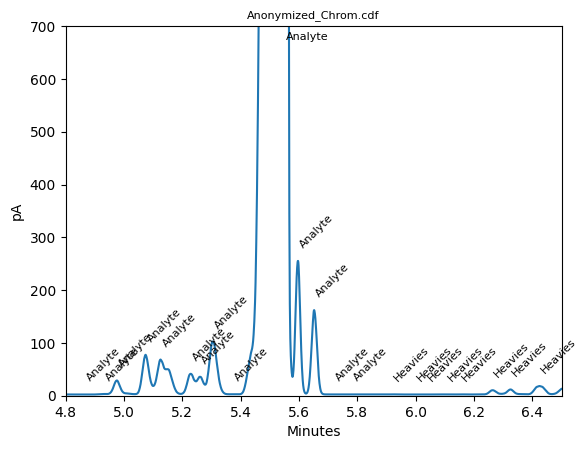

In [9]:
chrom.plot(xmin=4.8, xmax=6.5, ymax=700)